# **Combined Classification**

In [7]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
uploaded = files.upload()

Saving audio_test.csv to audio_test.csv
Saving audio_train.csv to audio_train.csv
Saving text_test.csv to text_test.csv
Saving text_train.csv to text_train.csv


In [8]:
x_train_text = pd.read_csv('text_train.csv')
x_test_text = pd.read_csv('text_test.csv')

y_train_text = x_train_text['label']
y_test_text = x_test_text['label']

x_train_audio = pd.read_csv('audio_train.csv')
x_test_audio = pd.read_csv('audio_test.csv')


y_train_audio = x_train_audio['label']
y_test_audio = x_test_audio['label']

y_train = y_train_audio  # since y_train_audio == y_train_text
y_test = y_test_audio  # since y_train_audio == y_train_text

print(x_train_text.shape, y_train_text.shape, x_train_audio.shape, y_train_audio.shape)

(7837, 3) (7837,) (7837, 10) (7837,)


In [9]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

id_to_emotion = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [10]:
cl_weight = dict(pd.Series(x_train_audio['label']).value_counts(normalize=True))

# ***Get Text Features***

In [11]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

# Use pd.concat to combine the DataFrames
combined_df = pd.concat([x_train_text, x_test_text], ignore_index=True)

# Apply fit_transform to the 'transcription' column of the combined DataFrame
features_text = tfidf.fit_transform(combined_df['transcription']).toarray()

# Split the features back into train and test sets
x_train_text = features_text[:x_train_text.shape[0]]
x_test_text = features_text[x_train_text.shape[0]:]

print(features_text.shape, x_train_text.shape, x_test_text.shape)

(9797, 2464) (7837, 2464) (1960, 2464)


# ***Get Text+ Audio Features***


In [12]:
combined_x_train = np.concatenate((np.array(x_train_audio[x_train_audio.columns[2:]]), x_train_text), axis=1)
combined_x_test = np.concatenate((np.array(x_test_audio[x_test_audio.columns[2:]]), x_test_text), axis=1)

print(combined_x_train.shape, combined_x_test.shape)

combined_features_dict = {}

combined_features_dict['x_train'] = combined_x_train
combined_features_dict['x_test'] = combined_x_test
combined_features_dict['y_train'] = np.array(y_train)
combined_features_dict['y_test'] = np.array(y_test)


(7837, 2472) (1960, 2472)


Test Set Accuracy =  0.661
Test Set F-score =  0.662
Test Set Precision =  0.714
Test Set Recall =  0.657
Confusion matrix, without normalization
[[ 92  18 105   0   2   7]
 [ 19 123 116   3   5  34]
 [ 20  29 491   1   7  35]
 [  0   0   0 247   0   0]
 [  0   0   0   0 241   0]
 [ 11  20 222   4   6 102]]


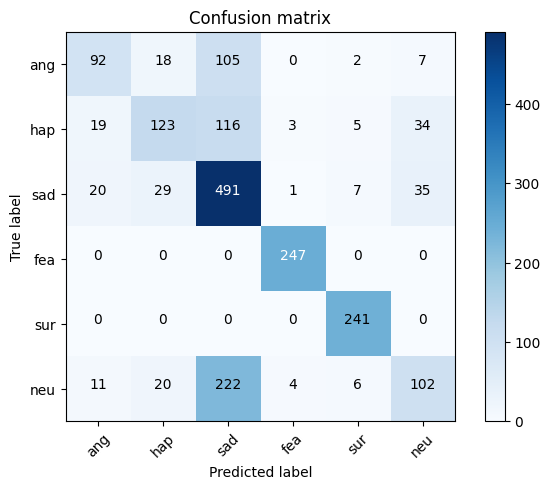

In [13]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Test Set Accuracy =  0.631
Test Set F-score =  0.643
Test Set Precision =  0.686
Test Set Recall =  0.620
Confusion matrix, without normalization
[[119   8  77   1   5  14]
 [  9 175  59   4  13  40]
 [ 28  29 449   4  18  55]
 [ 10   0  53 184   0   0]
 [  5   7  49   2 173   5]
 [  7  34 166   9  12 137]]


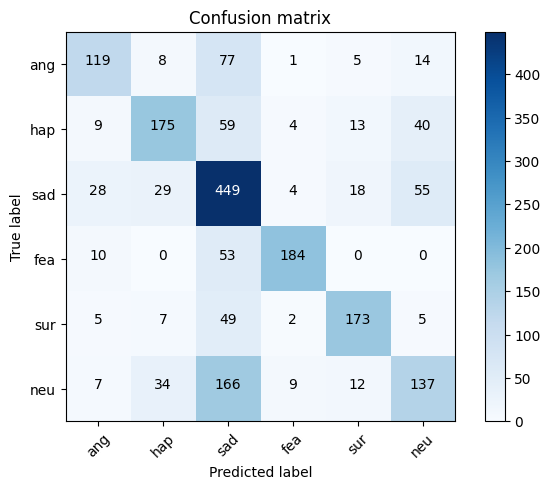

In [14]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)


# **CNN**

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np


# Reshape the data for CNN
combined_x_train_cnn = np.expand_dims(combined_x_train, axis=-1)
combined_x_test_cnn = np.expand_dims(combined_x_test, axis=-1)

# Define the CNN model
cnn_classifier = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(combined_x_train_cnn.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(emotion_dict), activation='softmax')
])

# Compile the model
cnn_classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
cnn_classifier.fit(combined_x_train_cnn, y_train, epochs=20, batch_size=32, validation_split=0.2)

#predict result
preb_probs_cnn = cnn_classifier.predict(combined_x_test_cnn)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 142s 710ms/step - accuracy: 0.4198 - loss: 1.4644 - val_accuracy: 0.6040 - val_loss: 1.0488
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 132s 673ms/step - accuracy: 0.6490 - loss: 0.9164 - val_accuracy: 0.6365 - val_loss: 0.9754
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 135s 687ms/step - accuracy: 0.7102 - loss: 0.7649 - val_accuracy: 0.6480 - val_loss: 0.9294
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 131s 669ms/step - accuracy: 0.7469 - loss: 0.6675 - val_accuracy: 0.6524 - val_loss: 0.9279
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 133s 680ms/step - accuracy: 0.7749 - loss: 0.6125 - val_accuracy: 0.6562 - val_loss: 0.9942
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 143s 685ms/step - accuracy: 0.8105 - loss: 0.5346 - val_accuracy: 0.6480 - val_loss: 0.9819
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 140s 675ms/step - accuracy: 0.8076 - loss: 0.5050 - val_accuracy: 0.6607 - val_loss: 1.0380
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 146s 695ms/step - accuracy: 0.8137 -

In [17]:
# Evaluate the model
test_loss, test_acc = cnn_classifier.evaluate(combined_x_test_cnn, y_test) # Replace 'model' with 'cnn_classifier'
print(f'Test Accuracy: {test_acc:.3f}')


62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.6625 - loss: 1.2398
Test Accuracy: 0.671


# **Transformer**

In [20]:
from google.colab import files
uploaded = files.upload()

Saving combined_features.pkl to combined_features.pkl


In [22]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Flatten, Reshape, Add
import pickle
import numpy as np

# Define a modified Transformer encoder block
def transformer_encoder(inputs):
    attention = MultiHeadAttention(num_heads=4, key_dim=64)(inputs, inputs)
    attention = Dropout(0.1)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention + inputs)

    dense_output = Dense(inputs.shape[-1], activation='relu')(attention)  # Match dimensions to input
    dense_output = Dropout(0.1)(dense_output)
    return LayerNormalization(epsilon=1e-6)(Add()([attention, dense_output]))

# Load combined features
with open('combined_features.pkl', 'rb') as f:
    combined_features_dict = pickle.load(f)

combined_x_train = combined_features_dict['x_train']
combined_x_test = combined_features_dict['x_test']
y_train = combined_features_dict['y_train']
y_test = combined_features_dict['y_test']

# Input layer for combined features
inputs = Input(shape=(combined_x_train.shape[1],))
reshaped_inputs = Reshape((1, combined_x_train.shape[1]))(inputs)  # Reshape to 3D for attention
x = transformer_encoder(reshaped_inputs)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(len(np.unique(y_train)), activation='softmax')(x)  # Assuming y_train contains emotion classes

# Create and compile the model
transformer_classifier = Model(inputs, outputs)
transformer_classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
transformer_classifier.fit(combined_x_train, y_train, epochs=10, batch_size=32, validation_split=0.2)



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3919 - loss: 1.7024

/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (32, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


196/196 ━━━━━━━━━━━━━━━━━━━━ 224s 1s/step - accuracy: 0.3923 - loss: 1.7008 - val_accuracy: 0.5804 - val_loss: 1.0461
Epoch 2/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.6025 - loss: 0.9981 - val_accuracy: 0.5886 - val_loss: 1.0820
Epoch 3/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.6444 - loss: 0.8999 - val_accuracy: 0.5906 - val_loss: 1.0228
Epoch 4/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.6542 - loss: 0.8490 - val_accuracy: 0.6033 - val_loss: 1.1343
Epoch 5/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 258s 1s/step - accuracy: 0.6979 - loss: 0.7657 - val_accuracy: 0.5976 - val_loss: 1.1993
Epoch 6/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.6927 - loss: 0.7535 - val_accuracy: 0.6052 - val_loss: 1.2104
Epoch 7/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7018 - loss: 0.7164 - val_accuracy: 0.6122 - val_loss: 1.3012
Epoch 8/10
196/196 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.7139 - loss: 0.6858 - val_accuracy: 0.596

In [23]:
# Predict results
pred_probs_transformer = transformer_classifier.predict(combined_x_test)

# Evaluate the model
test_loss, test_acc = transformer_classifier.evaluate(combined_x_test, y_test) # Replace 'model' with 'cnn_classifier'
print(f'Test Accuracy: {test_acc:.3f}')


62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6257 - loss: 1.3336
Test Accuracy: 0.636
